In [5]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    },
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [8]:
agg_strats = ['min','max']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [9]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

y_train_agg.loc[y_train_agg>4000] *= 1.05

In [10]:
# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")

categorical_features: ['building_id']
impute_features: ['min_ceiling_height_agl:m', 'min_cloud_base_agl:m', 'min_GHI_lag_-1h', 'min_GHI_lag_1h', 'min_temp*GHI_lag_-1h', 'min_temp*GHI_lag_1h', 'max_ceiling_height_agl:m', 'max_cloud_base_agl:m', 'max_GHI_lag_-1h', 'max_GHI_lag_1h', 'max_temp*GHI_lag_-1h', 'max_temp*GHI_lag_1h']


In [11]:
X_train_agg.describe()

,isEstimated,delta_forecast,month,hour,min_absolute_humidity_2m:gm3,min_air_density_2m:kgm3,min_ceiling_height_agl:m,min_clear_sky_energy_1h:J,min_clear_sky_rad:W,min_cloud_base_agl:m,min_dew_or_rime:idx,min_dew_point_2m:K,min_diffuse_rad:W,min_diffuse_rad_1h:J,min_direct_rad:W,min_direct_rad_1h:J,min_effective_cloud_cover:p,min_is_day:idx,min_is_in_shadow:idx,min_msl_pressure:hPa,min_precip_5min:mm,min_precip_type_5min:idx,min_pressure_100m:hPa,min_pressure_50m:hPa,min_prob_rime:p,min_rain_water:kgm2,min_relative_humidity_1000hPa:p,min_sfc_pressure:hPa,min_sun_azimuth:d,min_sun_elevation:d,min_super_cooled_liquid_water:kgm2,min_t_1000hPa:K,min_total_cloud_cover:p,min_visibility:m,min_wind_speed_10m:ms,min_wind_speed_u_10m:ms,min_wind_speed_v_10m:ms,min_wind_speed_w_1000hPa:ms,min_GHI,min_wind_angle,min_temp*GHI,min_wind*humidity,min_sun_height*diff_rad,min_wind_angle_sin,min_wind_angle_cos,min_hour_sin,min_hour_cos,min_GHI_daily_mean,min_GHI_daily_std,min_effective_cloud_cover_5h_mean,min_GHI_lag_-1h,min_GHI_lag_1h,min_temp*GHI_lag_-1h,min_temp*GHI_lag_1h,max_absolute_humidity_2m:gm3,max_air_density_2m:kgm3,max_ceiling_height_agl:m,max_clear_sky_energy_1h:J,max_clear_sky_rad:W,max_cloud_base_agl:m,max_dew_or_rime:idx,max_dew_point_2m:K,max_diffuse_rad:W,max_diffuse_rad_1h:J,max_direct_rad:W,max_direct_rad_1h:J,max_effective_cloud_cover:p,max_is_day:idx,max_is_in_shadow:idx,max_msl_pressure:hPa,max_precip_5min:mm,max_precip_type_5min:idx,max_pressure_100m:hPa,max_pressure_50m:hPa,max_prob_rime:p,max_rain_water:kgm2,max_relative_humidity_1000hPa:p,max_sfc_pressure:hPa,max_sun_azimuth:d,max_sun_elevation:d,max_super_cooled_liquid_water:kgm2,max_t_1000hPa:K,max_total_cloud_cover:p,max_visibility:m,max_wind_speed_10m:ms,max_wind_speed_u_10m:ms,max_wind_speed_v_10m:ms,max_wind_speed_w_1000hPa:ms,max_GHI,max_wind_angle,max_temp*GHI,max_wind*humidity,max_sun_height*diff_rad,max_wind_angle_sin,max_wind_angle_cos,max_hour_sin,max_hour_cos,max_GHI_daily_mean,max_GHI_daily_std,max_effective_cloud_cover_5h_mean,max_GHI_lag_-1h,max_GHI_lag_1h,max_temp*GHI_lag_-1h,max_temp*GHI_lag_1h
count,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,33141.000000,4.142500e+04,41425.000000,37731.000000,41425.000000,41425.000000,41425.000000,4.142500e+04,41425.000000,4.142500e+04,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,4.142500e+04,41425.000000,4.142500e+04,41425.000000,41425.000000,41425.000000,41422.000000,41423.000000,41422.000000,41423.000000,41425.000000,41425.000000,33141.000000,4.142500e+04,41425.000000,37731.000000,41425.000000,41425.000000,41425.000000,4.142500e+04,41425.000000,4.142500e+04,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,41425.000000,4.142500e+04,41425.000000,41425.000000,41425.000000,41422.000000,41423.000000,41422.000000,41423.000000
mean,0.089680,2.520460,5.922655,11.507809,7.200782,1.240923,2835.703613,7.702926e+05,214.018402,1686.992554,0.013374,278.190674,55.701508,2.026427e+05,72.538887,2.650906e+05,61.272064,0.609125,0.364490,1012.915894,0.002186,0.028123,999.371948,1005.443970,0.333864,0.010250,70.620033,1011.542480,167.783417,8.637863,0.046875,282.277435,67.974319,29625.880859,2.806066,0.766742,0.025811,0.000014,130.265732,0.140602,37124.589844,201.675552,1654.763672,0.126191,9.168655e-03,-0.000674,2.200535e-04,144.671112,154.095734,63.126548,130.2835

In [15]:
MAEs = []

for i in range(1):
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )


    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=8,
        random_seed=i*10+1,
    )

    open('status.csv', 'w').close()
    # build the pipeline
    mod_pipe = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('statusSaver', StatusSaver()),
        ('estimator', mod)
    ])

    mod_pipe.fit(X_train_agg, y_train_agg)

    pred = pd.Series(mod_pipe.predict(X_test_agg))

    mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
    print(f'MAE: {mae}')
    MAEs.append(mae)

MAEs = np.array(MAEs)

0:	learn: 0.1478359	total: 103ms	remaining: 1m 22s
1:	learn: 0.1439851	total: 155ms	remaining: 1m 1s
2:	learn: 0.1407747	total: 209ms	remaining: 55.4s
3:	learn: 0.1370401	total: 274ms	remaining: 54.6s
4:	learn: 0.1335249	total: 329ms	remaining: 52.3s
5:	learn: 0.1300968	total: 423ms	remaining: 56s
6:	learn: 0.1267714	total: 487ms	remaining: 55.2s
7:	learn: 0.1235350	total: 559ms	remaining: 55.4s
8:	learn: 0.1204309	total: 618ms	remaining: 54.4s
9:	learn: 0.1178028	total: 647ms	remaining: 51.1s
10:	learn: 0.1151110	total: 716ms	remaining: 51.3s
11:	learn: 0.1125214	total: 801ms	remaining: 52.6s
12:	learn: 0.1098072	total: 870ms	remaining: 52.6s
13:	learn: 0.1072686	total: 945ms	remaining: 53s
14:	learn: 0.1048478	total: 1.02s	remaining: 53.3s
15:	learn: 0.1024432	total: 1.09s	remaining: 53.5s
16:	learn: 0.1001259	total: 1.13s	remaining: 52.1s
17:	learn: 0.0979785	total: 1.24s	remaining: 53.7s
18:	learn: 0.0958606	total: 1.27s	remaining: 52.3s
19:	learn: 0.0939100	total: 1.36s	remaining:

In [16]:
#scale predictions

y_scaled = m_wrap.y_scalers[0].inverse_transform(pred,X_test_agg)


In [21]:
Xy_test_agg = pd.concat([X_test_agg,y_test_agg.rename('pv_measurement'),y_scaled.clip(0).rename('mean')],axis=1)
Xy_test_agg.rename(columns={'min_GHI':'GHI'},inplace=True)

In [22]:
Xy_test_agg[['building_id','pv_measurement','GHI','mean']].to_csv('transfer.csv',index=False)


In [ ]:
err

MAEs: [139.39475982 140.14412382 140.14685629 140.43191035 140.48478896
 140.92898919 141.03352672 141.05379338 141.23398728 141.25381582]
MAE mean: 140.61065516357985


<Axes: >

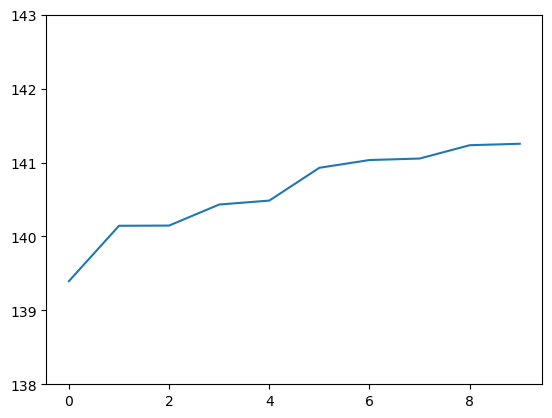

In [ ]:
# sort maes
MAEs.sort()

print(f"MAEs: {MAEs}")
print(f"MAE mean: {np.mean(MAEs)}")

plt.ylim(138,143)
sns.lineplot(x=range(len(MAEs)),y=MAEs)

In [ ]:
X_test_agg

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,min_absolute_humidity_2m:gm3,min_air_density_2m:kgm3,min_ceiling_height_agl:m,min_clear_sky_energy_1h:J,min_clear_sky_rad:W,min_cloud_base_agl:m,min_dew_or_rime:idx,min_dew_point_2m:K,min_diffuse_rad:W,min_diffuse_rad_1h:J,min_direct_rad:W,min_direct_rad_1h:J,min_effective_cloud_cover:p,min_is_day:idx,min_is_in_shadow:idx,min_precip_5min:mm,min_precip_type_5min:idx,min_prob_rime:p,min_rain_water:kgm2,min_relative_humidity_1000hPa:p,min_sun_azimuth:d,min_sun_elevation:d,min_super_cooled_liquid_water:kgm2,min_t_1000hPa:K,min_total_cloud_cover:p,min_visibility:m,min_wind_speed_10m:ms,min_wind_speed_u_10m:ms,min_wind_speed_v_10m:ms,min_wind_speed_w_1000hPa:ms,min_date_calc,min_GHI,min_wind_angle,min_temp*GHI,min_wind*humidity,min_sun_height*diff_rad,min_wind_angle_sin,min_wind_angle_cos,min_hour_sin,min_hour_cos,min_GHI_daily_mean,min_GHI_daily_std,min_effective_cloud_cover_5h_mean,min_GHI_lag_-1h,min_GHI_lag_1h,min_temp*GHI_lag_-1h,min_temp*GHI_lag_1h,min_effective_cloud_cover:p_-1h,min_effective_cloud_cover:p_1h,min_cloud_base_agl:m_-1h,min_cloud_base_agl:m_1h,max_absolute_humidity_2m:gm3,max_air_density_2m:kgm3,max_ceiling_height_agl:m,max_clear_sky_energy_1h:J,max_clear_sky_rad:W,max_cloud_base_agl:m,max_dew_or_rime:idx,max_dew_point_2m:K,max_diffuse_rad:W,max_diffuse_rad_1h:J,max_direct_rad:W,max_direct_rad_1h:J,max_effective_cloud_cover:p,max_is_day:idx,max_is_in_shadow:idx,max_precip_5min:mm,max_precip_type_5min:idx,max_prob_rime:p,max_rain_water:kgm2,max_relative_humidity_1000hPa:p,max_sun_azimuth:d,max_sun_elevation:d,max_super_cooled_liquid_water:kgm2,max_t_1000hPa:K,max_total_cloud_cover:p,max_visibility:m,max_wind_speed_10m:ms,max_wind_speed_u_10m:ms,max_wind_speed_v_10m:ms,max_wind_speed_w_1000hPa:ms,max_date_calc,max_GHI,max_wind_angle,max_temp*GHI,max_wind*humidity,max_sun_height*diff_rad,max_wind_angle_sin,max_wind_angle_cos,max_hour_sin,max_hour_cos,max_GHI_daily_mean,max_GHI_daily_std,max_effective_cloud_cover_5h_mean,max_GHI_lag_-1h,max_GHI_lag_1h,max_temp*GHI_lag_-1h,max_temp*GHI_lag_1h,max_effective_cloud_cover:p_-1h,max_effective_cloud_cover:p_1h,max_cloud_base_agl:m_-1h,max_cloud_base_agl:m_1h
0,a,2021-05-01 00:00:00,0,0.0,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.7,1.288,2263.399902,0.000000,0.000000,368.299988,0.0,272.700012,0.0,0.000000,0.0,0.000000,75.000000,0.0,1.0,0.0,0.0,0.0,0.0,85.699997,10.054000,-11.075,0.0,274.000000,75.000000,16799.400391,1.7,1.7,0.3,-0.0,NaT,0.0,1.325818,0.000000,145.690002,-0.000000,0.970142,1.737853e-01,0.000000,1.000000,189.842712,206.237961,79.671428,0.000000,0.000000,0.000000,0.000000,87.800003,72.300003,366.600006,400.399994,4.8,1.288,2263.399902,0.000000,0.000000,399.500000,0.0,273.000000,0.0,0.000000,0.0,0.000000,84.900002,0.0,1.0,0.0,0.0,0.0,0.0,86.800003,21.042000,-9.724,0.1,274.200012,85.099998,16991.199219,2.1,2.0,0.5,-0.0,NaT,0.000000,1.396124,0.000000,182.279999,-0.000000,0.984784,2.425356e-01,0.000000,1.000000,189.842712,206.237961,84.652381,0.000000,0.000000,0.000000,0.000000,96.500000,74.199997,409.899994,496.700012
1,a,2021-05-01 01:00:00,0,0.0,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.6,1.287,1079.400024,0.000000,0.000000,366.600006,0.0,272.500000,0.0,0.000000,0.0,0.000000,87.800003,0.0,1.0,0.0,0.0,0.0,0.0,85.300003,24.662001,-9.071,0.1,273.899994,87.900002,17086.199219,1.6,1.6,0.2,-0.0,NaT,0.0,1.325818,0.000000,136.480011,-0.000000,0.970142,1.240348e-01,0.258819,0.965926,189.842712,206.237961,86.133333,0.000000,0.000000,0.000000,0.000000,97.900002,75.000000,342.799988,368.299988,4.6,1.288,2263.399902,0.000000,0.000000,409.899994,0.0,272.600006,0.0,0.000000,0.0,0.000000,96.500000,0.0,1.0,0.0,0.0,0.0,0.0,85.900002,35.356998,-6.550,0.1,274.000000,96.500000,17549.599609,1.7,1.6,0.4,-0.0,NaT,0.000000,1.446441,0.000000,146.030014,-0.000000,0.992278,2.425356e-01,0.258819,0.965926,189.842712,206.237961,90.138095,0.000000,0.000000,0.000000,0.000000,98.400002,

In [ ]:
err

NameError: name 'err' is not defined

In [ ]:
# gs.best_params_

In [ ]:
model = mod_pipe#gs.best_estimator_

In [ ]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

In [ ]:
# for key, values in gs.param_grid.items():
#     pass

# plt.figure(figsize=(20, 5))
# # plt.ylim(0.05, 0.0525)
# sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
# plt.xticks(rotation=90);

# plt.figure(figsize=(20, 5))
# sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
# plt.xticks(rotation=90);

MAE: 143.02005295063796


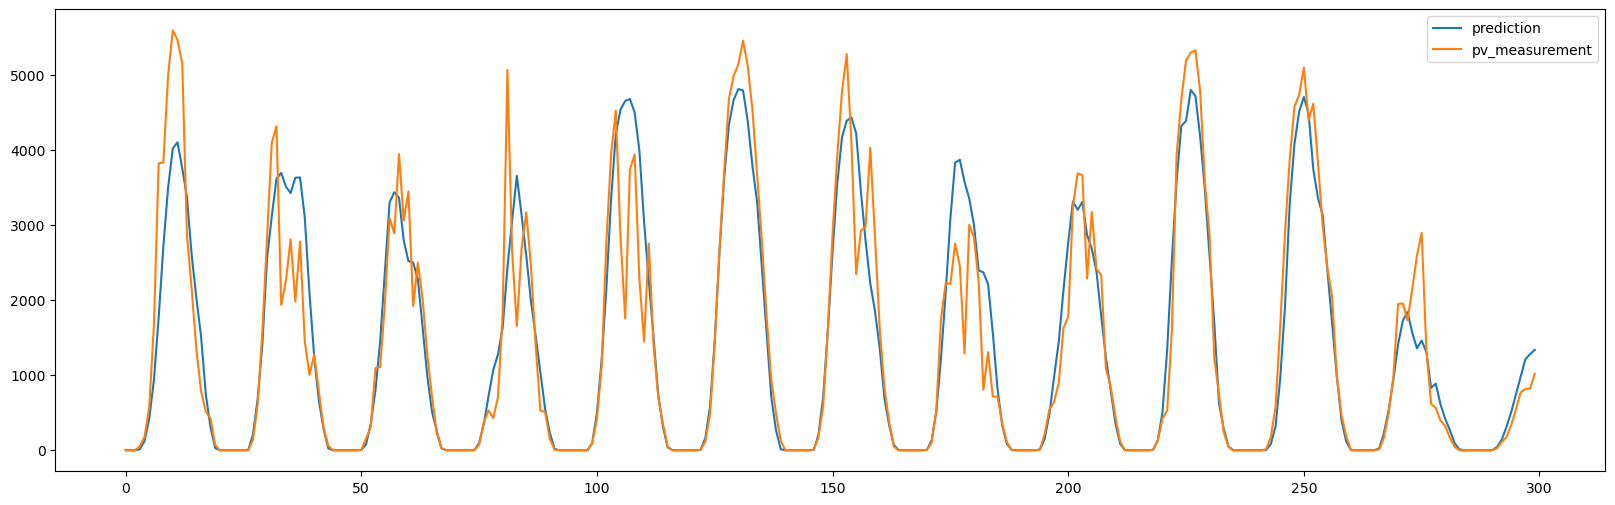

In [ ]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=0,end_idx=300)

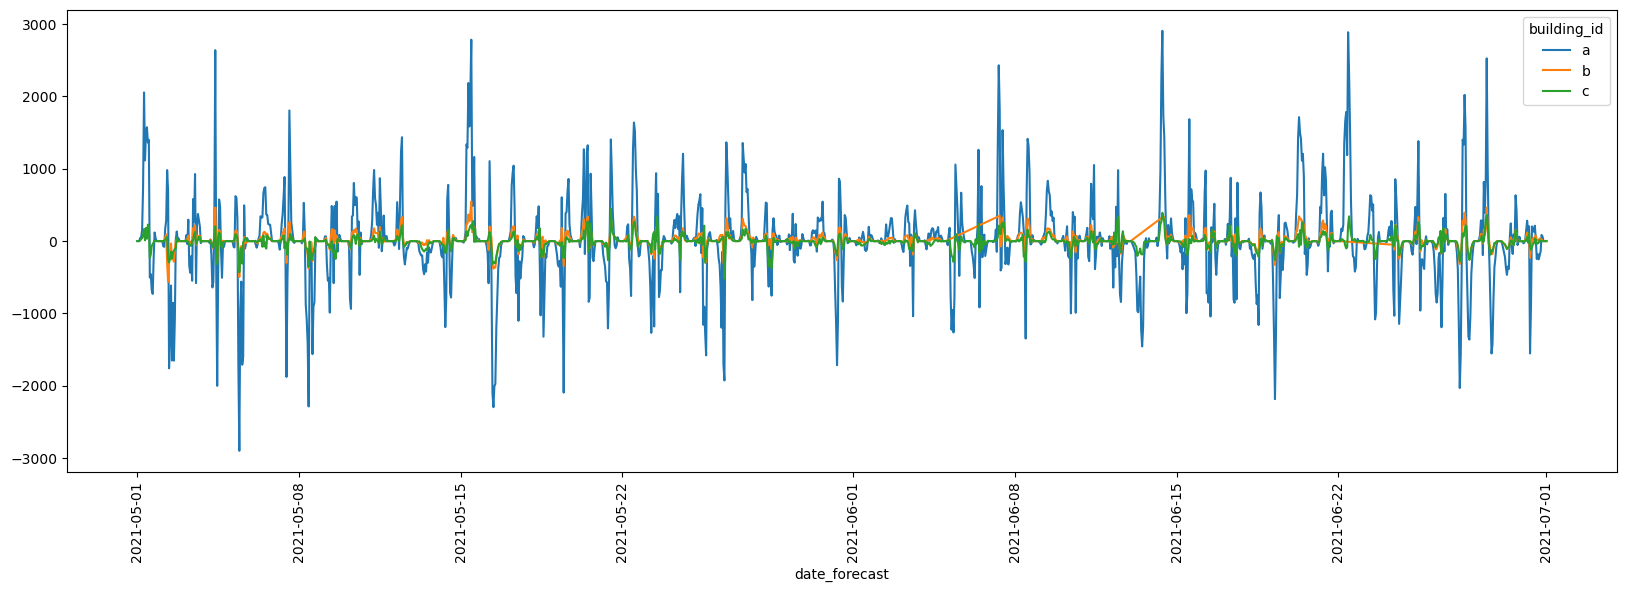

In [ ]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [ ]:
model

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_lag_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x29eee77d0>)])

In [ ]:
X_all, y_all = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_all = X_all.select_dtypes(exclude=['datetime','timedelta','period[M]'])

model.fit(X_all, y_all)

0:	learn: 0.1545581	total: 19.7ms	remaining: 15.7s
1:	learn: 0.1507532	total: 36.9ms	remaining: 14.7s
2:	learn: 0.1471160	total: 58.3ms	remaining: 15.5s
3:	learn: 0.1432983	total: 74.7ms	remaining: 14.9s
4:	learn: 0.1395582	total: 91.4ms	remaining: 14.5s
5:	learn: 0.1359937	total: 109ms	remaining: 14.5s
6:	learn: 0.1327512	total: 126ms	remaining: 14.3s
7:	learn: 0.1295188	total: 142ms	remaining: 14s
8:	learn: 0.1262082	total: 157ms	remaining: 13.8s
9:	learn: 0.1230312	total: 174ms	remaining: 13.7s
10:	learn: 0.1200834	total: 191ms	remaining: 13.7s
11:	learn: 0.1173085	total: 207ms	remaining: 13.6s
12:	learn: 0.1145436	total: 223ms	remaining: 13.5s
13:	learn: 0.1120606	total: 242ms	remaining: 13.6s
14:	learn: 0.1094457	total: 259ms	remaining: 13.5s
15:	learn: 0.1071279	total: 276ms	remaining: 13.5s
16:	learn: 0.1048403	total: 297ms	remaining: 13.7s
17:	learn: 0.1024706	total: 313ms	remaining: 13.6s
18:	learn: 0.1001557	total: 330ms	remaining: 13.6s
19:	learn: 0.0979888	total: 350ms	rema

In [ ]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='catboost_all.csv',sun_el_thr=1)

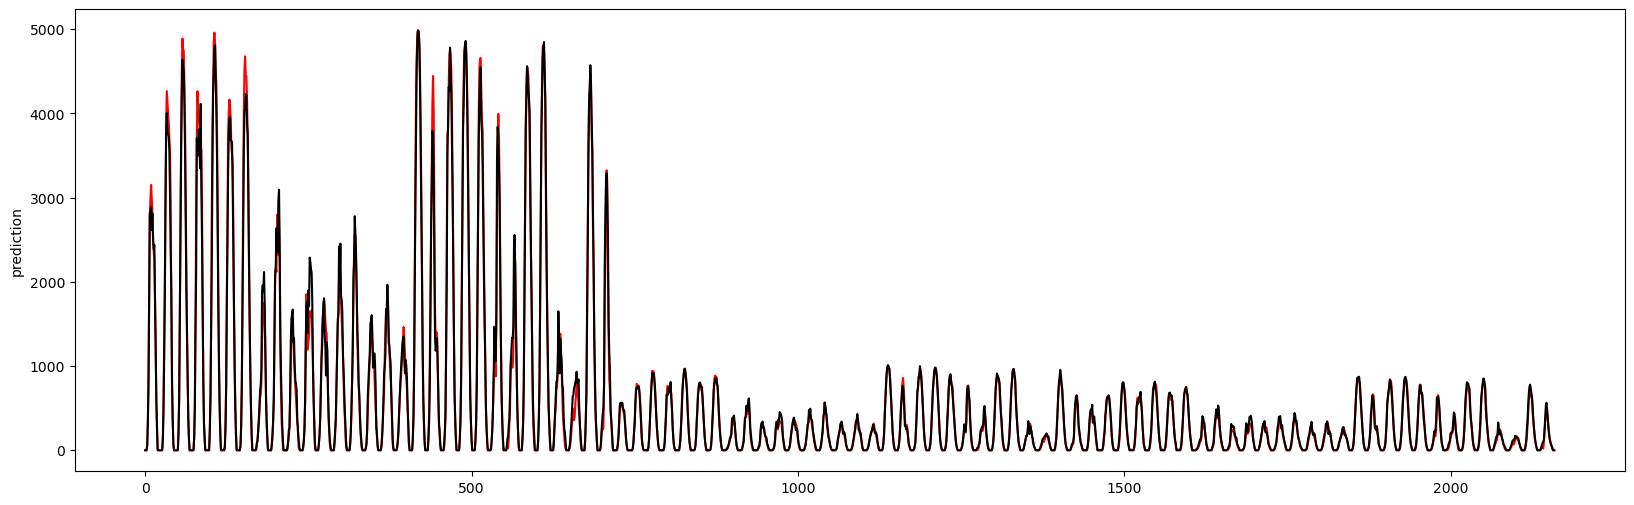

In [ ]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')